In [1]:
import string
import numpy as np
from PIL import Image
import os
import pandas as pd
from pickle import dump, load
import numpy as np
from collections import Counter 
from keras.applications.xception import Xception, preprocess_input
from keras_preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
import pickle
import matplotlib.pyplot as plt
# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm

tqdm().pandas()

C:\Users\prath\AppData\Local\Temp\ipykernel_7392\2559071088.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [2]:
df_images = r"Flickr8k_Dataset\Flicker8k_Dataset"
df_text = r"Flickr8k_text"
filename1 = r"Flickr8k_text\Flickr8k.token.txt"#run in start before text preprocessing

In [3]:
filename1

'Flickr8k_text\\Flickr8k.token.txt'

In [4]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    #print(captions[1])
    descriptions ={}
    #print(captions[1].split(',')[0])
    for caption in captions[:-1]:
        #print(caption)
        img= caption.split('\t')[0]
        caption=caption.split('\t')[1]
        #print(img[:-4],"  ",caption)
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions
descriptions=all_img_captions(filename1)

def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    #print(table)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            desc = [word.lower() for word in desc]
            desc = [word.translate(table) for word in desc]
            desc = [word for word in desc if(len(word)>1)]
            desc = [word for word in desc if(word.isalpha())]
            img_caption = ' '.join(desc)
            #print(captions)
            captions[img][i]= img_caption
    return captions
clean_descriptions = cleaning_text(descriptions)

In [18]:
list(clean_descriptions)[0]

'1000268201_693b08cb0e.jpg'

In [7]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = 'Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)

# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

import string

def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

Loaded: 8092 


In [8]:
from keras_preprocessing.image import load_img, img_to_array
import imageio

def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img_ in tqdm(os.listdir(directory)):
            filename = directory+ "" + img_
            print(filename)
            image = imageio.imread(filename)
            # img = Image.open(filename)
            image = img_to_array(img)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            features[img_] = feature
        return filename

ModuleNotFoundError: No module named 'imageio'

In [9]:
# def t_vocabulary(descriptions):
#     vocab = set()
#     for key in descriptions.keys():
#         [vocab.update(d.split()) for d in descriptions[key]]
#     return vocab
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8763


In [10]:
descriptions.items()

dict_items([('1000268201_693b08cb0e', ['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']), ('1001773457_577c3a7d70', ['black dog and spotted dog are fighting', 'black dog and tricolored dog playing with each other on the road', 'black dog and white dog with brown spots are staring at each other in the street', 'two dogs of different breeds looking at each other on the road', 'two dogs on pavement moving toward each other']), ('1002674143_1b742ab4b8', ['little girl covered in paint sits in front of painted rainbow with her hands in bowl', 'little girl is sitting in front of large painted rainbow', 'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it', 'there is girl with pigtails sitting in front of rainbow painting', 'young girl with pigtails pai

In [10]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()   

In [11]:
save_descriptions(descriptions, "descriptions.txt")

In [12]:
# from keras.preprocessing import image
import keras.utils as image

In [18]:
# def extract_features(directory):
#         model = Xception( include_top=False, pooling='avg' )
#         features = {}
#         for img_ in tqdm(os.listdir(directory)):
#             filename = directory+ "/" + img_
#             img = Image.open(filename)
#             img = image.img_to_array(img)
#             img = img.resize((299,299))
#             img = np.expand_dims(img, axis=0)
#             #image = preprocess_input(image)
#             img = img/127.5
#             img = img - 1.0
#             feature = model.predict(img)
#             features[img_] = feature
#         return features

In [107]:
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

# extract features from each photo in the directory
def extract_features(directory):
	# load the model
	model = VGG16()
	# re-structure the model
	model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
	# summarize
	print(model.summary())
	# extract features from each photo
	features = dict()
	for name in listdir(directory):
		# load an image from file
		filename = directory + '/' + name
		image = load_img(filename, target_size=(224, 224))
		# convert the image pixels to a numpy array
		image = img_to_array(image)
		# reshape data for the model
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		# prepare the image for the VGG model
		image = preprocess_input(image)
		# get features
		feature = model.predict(image, verbose=0)
		# get image id
		image_id = name.split('.')[0]
		# store feature
		features[image_id] = feature
		print('>%s' % name)
	return features

# extract features from all images
directory = 'Flickr8k_Dataset/Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features_vgg.pkl', 'wb'))

553476096/553467096 [==============================] - 195s 0us/step
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                        

>1204996216_71d7519d9a.jpg
>1206506157_c7956accd5.jpg
>1207159468_425b902bfb.jpg
>1211015912_9f3ee3a995.jpg
>1213336750_2269b51397.jpg
>1215334959_b1970965f7.jpg
>121800200_bef08fae5f.jpg
>121971540_0a986ee176.jpg
>1220401002_3f44b1f3f7.jpg
>1222322358_225067636e.jpg
>1224851143_33bcdd299c.jpg
>1225443522_1633e7121f.jpg
>1227655020_b11a1bb112.jpg
>1229756013_94663527d7.jpg
>1231229740_8dcbf80bfb.jpg
>1232148178_4f45cc3284.jpg
>1234293791_6566284bcd.jpg
>1234817607_924893f6e1.jpg
>1235580648_7eebaed9bc.jpg
>1235681222_819231767a.jpg
>1235685934_be89b231fb.jpg
>1236951314_0308dc4138.jpg
>1236964638_1808784a3c.jpg
>1237985362_dbafc59280.jpg
>123889082_d3751e0350.jpg
>123997871_6a9ca987b1.jpg
>1240297429_c36ae0c58f.jpg
>124195430_d14028660f.jpg
>1244140539_da4804d828.jpg
>1244306891_8e78ae1620.jpg
>1244485675_822e6efe60.jpg
>1245022983_fb329886dd.jpg
>1247181182_35cabd76f3.jpg
>1248357227_2b4175fc39.jpg
>1248734482_3038218f3b.jpg
>124881487_36e668145d.jpg
>1248940539_46d33ed487.jpg
>124895

>1449692616_60507875fb.jpg
>1452361926_6d8c535e32.jpg
>1453366750_6e8cf601bf.jpg
>1454678644_7e5a371301.jpg
>1454841725_4b6e6199e2.jpg
>1456393634_74022d9056.jpg
>1456630952_dd4778a48f.jpg
>145721496_687af9bb18.jpg
>145721498_a27d2db576.jpg
>1457762320_7fe121b285.jpg
>1459032057_97e73ed6ab.jpg
>1459250022_bf1eddad11.jpg
>1460352062_d64fb633e0.jpg
>1460500597_866fa0c6f3.jpg
>146098876_0d99d7fb98.jpg
>146100443_906d87faa2.jpg
>1461329041_c623b06e5b.jpg
>1461653394_8ab96aae63.jpg
>1461667284_041c8a2475.jpg
>1463638541_c02cfa04dc.jpg
>1463732130_a754441289.jpg
>1463732807_0cdf4f22c7.jpg
>1464120327_d90279ca3a.jpg
>1465666502_de289b3b9c.jpg
>146577645_91b570c0d0.jpg
>146577646_9e64b8c2dc.jpg
>1466307485_5e6743332e.jpg
>1466307489_cb8a74de09.jpg
>1466479163_439db855af.jpg
>1467533293_a2656cc000.jpg
>1468103286_96a6e07029.jpg
>1468389504_c724bdcad0.jpg
>1468429623_f001988691.jpg
>1468962616_5803b4397f.jpg
>1469000260_5d473c8283.jpg
>1469358746_2a879abaf3.jpg
>1470061031_4cb59c12a8.jpg
>147013

>1917265421_aeccf1ca38.jpg
>1918573100_d31cbb6b77.jpg
>19212715_20476497a3.jpg
>1921398767_771743bf4e.jpg
>1923476156_e20976b32d.jpg
>1924234308_c9ddcf206d.jpg
>1925434818_2949a8f6d8.jpg
>1926129518_4350f4f552.jpg
>1928319708_ccf1f4ee72.jpg
>1931690777_897a7d8ab6.jpg
>1932161768_996eadac87.jpg
>1932314876_9cc46fd054.jpg
>1936215201_d03a75cbba.jpg
>1937104503_313d22a2d0.jpg
>1937262236_cbf5bfa101.jpg
>1947351225_288d788983.jpg
>195084264_72fb347b0f.jpg
>1952896009_cee8147c90.jpg
>1956678973_223cb1b847.jpg
>1956944011_c5661d3f22.jpg
>1957371533_62bc720bac.jpg
>195962284_e57178054a.jpg
>195962790_3380aea352.jpg
>1962729184_6996e128e7.jpg
>1965278563_8279e408de.jpg
>1969573381_5ecfae4c80.jpg
>197107117_4b438b1872.jpg
>197142902_f05ff198c2.jpg
>197504190_fd1fc3d4b7.jpg
>1975171469_84e425f61b.jpg
>1975531316_8b00eeaaf7.jpg
>1977827746_4e13d7e19f.jpg
>197924859_f6e39a7dfa.jpg
>1980315248_82dbc34676.jpg
>1980882959_9a161f3469.jpg
>1982852140_56425fa7a2.jpg
>1984936420_3f3102132b.jpg
>198914528

>214501174_6db1f4d69c.jpg
>214543992_ce6c0d9f9b.jpg
>2147199188_d2d70b88ec.jpg
>2148013097_6a4f495bc5.jpg
>2148695079_9ae6a9b1c7.jpg
>2148916767_644ea6a7fa.jpg
>2148991939_3b9fd6c439.jpg
>2149968397_a7411729d1.jpg
>2149982207_5345633bbf.jpg
>2150564996_d173a506d7.jpg
>2151056407_c9c09b0a02.jpg
>2151300603_248a9fe715.jpg
>215214751_e913b6ff09.jpg
>2156131463_5b53636cf0.jpg
>2156726763_034ecd2e39.jpg
>2157003092_eaeb977789.jpg
>2157173498_2eea42ee38.jpg
>2158247955_484f0a1f11.jpg
>2158267555_db1d94e468.jpg
>215876547_fa584c5ec3.jpg
>2159447283_fab8c272b0.jpg
>2160266952_a2ab39191b.jpg
>216172386_9ac5356dae.jpg
>2161799386_27aa938421.jpg
>2162469360_ff777edc95.jpg
>2162564553_96de62c7e6.jpg
>2164363131_6930455d45.jpg
>2165459064_5b81ff23eb.jpg
>2165461920_1a4144eb2b.jpg
>2165677531_e1d5e086f7.jpg
>2167644298_100ca79f54.jpg
>2169067981_cc19268f23.jpg
>2169951750_495820a215.jpg
>2170187328_65c2f11891.jpg
>2170222061_e8bce4a32d.jpg
>2171154778_8189169336.jpg
>2171576939_d1e72daab2.jpg
>21718

>2272823323_3b7291cd47.jpg
>2272967004_1531726d71.jpg
>2273028514_d7b584f73d.jpg
>2273038287_3004a72a34.jpg
>2273105617_7c73d2d2d3.jpg
>2273591668_069dcb4641.jpg
>2273799395_5072a5736d.jpg
>2273871383_1ddb3562ea.jpg
>2274602044_b3d55df235.jpg
>2274992140_bb9e868bb8.jpg
>2275029674_6d4891c20e.jpg
>2275253272_00f941366e.jpg
>2275372714_017c269742.jpg
>2276120079_4f235470bc.jpg
>2276314067_7ee246f859.jpg
>2276499757_b44dc6f8ce.jpg
>2277081067_d2b4c98bce.jpg
>2277299634_e14bdb7ff7.jpg
>2278110011_ba846e7795.jpg
>2278766574_f71f1704a8.jpg
>2278776373_fe499a93be.jpg
>2279496715_8ef3ee6edb.jpg
>2279945145_8815c59217.jpg
>2279980395_989d48ae72.jpg
>2280354512_c0d035d53f.jpg
>2280525192_81911f2b00.jpg
>2281006675_fde04e93dd.jpg
>2281054343_95d6d3b882.jpg
>2281075738_230892b241.jpg
>2281768510_9cc5728c55.jpg
>2282043629_91b7831352.jpg
>2282260240_55387258de.jpg
>2282522980_45cfa8e0cf.jpg
>2282600972_c22d1e03c7.jpg
>2282895743_f803f1cf01.jpg
>2283966256_70317e1759.jpg
>2284239186_c827f4defa.jpg
>

>2392625002_83a5a0978f.jpg
>2393196444_8f4f540f5f.jpg
>2393264648_a280744f97.jpg
>2393298349_e659308218.jpg
>2393410666_b8c20fff61.jpg
>2393911878_68afe6e6c1.jpg
>2393924525_1bf45ca217.jpg
>2393971707_bce01ae754.jpg
>2394003437_184a838aa9.jpg
>2394267183_735d2dc868.jpg
>239453674_0df7767208.jpg
>2394763838_99d1435b85.jpg
>2394824046_51cec8e5e7.jpg
>2394857899_76bfdf720b.jpg
>2394919002_ed7527ff93.jpg
>2394922193_310166d6af.jpg
>2395967330_7e6ea404f6.jpg
>2396025708_e4a72e2558.jpg
>2396100671_3a9d67f03d.jpg
>2396669903_5217a83641.jpg
>2396691909_6b8c2f7c44.jpg
>2396746868_0727e06983.jpg
>239807547_4923efc821.jpg
>2398605966_1d0c9e6a20.jpg
>2399114095_c3196ff456.jpg
>2399219552_bbba0a9a59.jpg
>2399551242_c62a46dd5f.jpg
>2400958566_4e09424046.jpg
>2402462857_7684848704.jpg
>2402744031_11f9f2f2b8.jpg
>2402793046_3385554e81.jpg
>2403078014_4b1d6f8bde.jpg
>2403376030_903521c371.jpg
>2403544744_cba152f5c1.jpg
>2404488732_ca1bbdacc2.jpg
>2404520067_87798dbaee.jpg
>2404692474_37da774368.jpg
>24

>2472250097_a3191a94b3.jpg
>2472574160_8ce233f396.jpg
>2472634822_7d5d2858c0.jpg
>2472678549_67068a1566.jpg
>2472720629_d9a6736356.jpg
>2472896179_245e7d142f.jpg
>2472980433_210ec62874.jpg
>2473293833_78820d2eaa.jpg
>2473689180_e9d8fd656a.jpg
>2473737724_355599a263.jpg
>2473738924_eca928d12f.jpg
>2473791980_805c819bd4.jpg
>2474047296_fd9179d438.jpg
>2474092890_6c0781a8ed.jpg
>2474918824_88660c7757.jpg
>2475162978_2c51048dca.jpg
>2475300106_b8563111ba.jpg
>247617035_9f2e821534.jpg
>247617754_4b1137de8c.jpg
>247618600_239eeac405.jpg
>247619370_a01fb21dd3.jpg
>2476214153_99a3998509.jpg
>247637795_fdf26a03cf.jpg
>247652942_29ede19352.jpg
>247691240_3881777ab8.jpg
>247704641_d883902277.jpg
>247706586_7e25c7adf8.jpg
>2477121456_1ac5c6d3e4.jpg
>2477623312_58e8e8c8af.jpg
>247778426_fd59734130.jpg
>2478929971_9eb6c074b6.jpg
>2479162876_a5ce3306af.jpg
>2479180530_7ebba2d8bf.jpg
>2479553749_f7ac031940.jpg
>2479652566_8f9fac8af5.jpg
>2480021389_dda9fb2818.jpg
>2480327661_fb69829f57.jpg
>2480664591

>2573667207_a1bf49befc.jpg
>2574084102_f2be3f73cb.jpg
>2574194729_1f099647ee.jpg
>2574230252_f5a1382dd4.jpg
>2574509968_e4692ae169.jpg
>2575647360_f5de38c751.jpg
>257588281_39e1c9d929.jpg
>2576878141_87f25a10f0.jpg
>2577972703_a22c5f2a87.jpg
>2578003921_e23b78e85f.jpg
>2578161080_e007c9177a.jpg
>2578289278_01516d23a0.jpg
>2578395598_6982734d46.jpg
>2578834476_118585730d.jpg
>2579266054_1ec58aa92f.jpg
>2579268572_d78f8436cb.jpg
>2579460386_94c489028d.jpg
>2579572274_826598b14a.jpg
>2579899436_5086a33c7a.jpg
>2580215443_4e64afe3d5.jpg
>2581066814_179d28f306.jpg
>2582390123_71120edb0c.jpg
>2583001715_1ce6f58942.jpg
>2584020755_14e2b3e8fc.jpg
>2584412512_6767593f24.jpg
>2584487952_f70e5aa9bf.jpg
>258476074_f28f4a1ae6.jpg
>2584957647_4f9235c150.jpg
>2585141045_b496a7b7c4.jpg
>2586028627_ddd054d8cc.jpg
>2586532797_dcf22a5021.jpg
>2586911841_41b7a48c91.jpg
>2587017287_888c811b5a.jpg
>2587106431_1cc0e719c6.jpg
>2587696611_db0378710f.jpg
>2587818583_4aa8e7b174.jpg
>2587846523_b177c9a3e3.jpg
>25

>2676184321_858eff416b.jpg
>2676648667_cb055b4fc6.jpg
>2676649969_482caed129.jpg
>2676651833_3bb42bbb32.jpg
>2676764246_c58205a365.jpg
>2676937700_456134c7b5.jpg
>2677614492_792023b928.jpg
>2677656448_6b7e7702af.jpg
>267836606_bbea2267c8.jpg
>2678612999_893ed671f8.jpg
>2678798732_2998f9969c.jpg
>2679565682_91ecd283ff.jpg
>2679851489_a58780291e.jpg
>2679926555_b11cf45595.jpg
>2680619645_ab6645218d.jpg
>2680990587_eee6bd04fb.jpg
>2681215810_00b0642f7b.jpg
>2682194299_92005b26c6.jpg
>2682382530_f9f8fd1e89.jpg
>268365231_a0acecdc45.jpg
>2683963310_20dcd5e566.jpg
>2683985894_167d267dcb.jpg
>2684322797_85406f571d.jpg
>2684323357_c7a6d05d05.jpg
>2684489465_32ba1d0344.jpg
>2685139184_4ff45e0f76.jpg
>2685752892_9d5cd7f274.jpg
>2685788323_ceab14534a.jpg
>2686432878_0697dbc048.jpg
>268654674_d29e00b3d0.jpg
>268704620_8a8cef4cb3.jpg
>2687229880_97cfd8148e.jpg
>2687328779_b4356dab16.jpg
>2687529141_edee32649e.jpg
>2687539673_d54a8dc613.jpg
>2687672606_275169c35d.jpg
>2688102742_885e578a3f.jpg
>2688

>278007543_99f5a91a3e.jpg
>2780087302_6a77658cbf.jpg
>2780105274_52360c4cca.jpg
>278105206_df987b0ca0.jpg
>2781296531_f6f0f6c0f5.jpg
>2782433864_5a0c311d87.jpg
>2782480767_064c95eff2.jpg
>2782850287_1408f7ec43.jpg
>2783620390_02c166c733.jpg
>278388986_78ba84eb8f.jpg
>2784408839_53a25a21eb.jpg
>2784625888_71a421e171.jpg
>278496691_c1fd93e2d8.jpg
>2785108434_cd4a1c949c.jpg
>2785115802_137fa30000.jpg
>278559394_b23af734b9.jpg
>278608022_4175813019.jpg
>2786245676_0a69543832.jpg
>2786299623_a3c48bd318.jpg
>2787276494_82703f570a.jpg
>2787868417_810985234d.jpg
>2788628994_61123c03d2.jpg
>2788652511_4f10060e07.jpg
>2788945468_74a9618cfa.jpg
>2789238858_14261dd25a.jpg
>2789350645_96a2535b4d.jpg
>2789648482_1df61f224a.jpg
>2789688929_9424fceed1.jpg
>2789937754_5d1fa62e95.jpg
>2790909995_8b7a03d9d1.jpg
>2792195540_af5fb95caa.jpg
>2792212974_23b1ef05fa.jpg
>279230262_e541f9b670.jpg
>2792409624_2731b1072c.jpg
>2795287622_da187a3e86.jpg
>2795352290_9209b214f3.jpg
>279550225_d64d56158a.jpg
>27958668

>2878190821_6e4e03dc5f.jpg
>2878272032_fda05ffac7.jpg
>2878578240_caf64c3b19.jpg
>2878705136_609dfbf318.jpg
>2879241506_b421536330.jpg
>287999021_998c2eeb91.jpg
>2880051254_e0ca96b6be.jpg
>288025239_5e59ba9c3b.jpg
>2880874989_a33b632924.jpg
>2881087519_ca0aa79b2b.jpg
>2881441125_b580e3dd4b.jpg
>2881468095_d4ce8c0c52.jpg
>288177922_b889f2e1fe.jpg
>2882056260_4399dd4d7c.jpg
>2882483779_73c171ac19.jpg
>2882589788_cb0b407a8d.jpg
>2882743431_c3e6cd1b5c.jpg
>2882893687_1d10d68f2b.jpg
>2883099128_0b056eed9e.jpg
>2883324329_24361e2d49.jpg
>2883907436_82bf4a36b8.jpg
>2883950737_3b67d24af4.jpg
>2884092603_786b53a74b.jpg
>2884252132_5d8e776893.jpg
>2884301336_dc8e974431.jpg
>2884400562_e0851014fc.jpg
>2884420269_225d27f242.jpg
>2884651479_12e400ee58.jpg
>288508162_1727873924.jpg
>2885111681_dc328ecfff.jpg
>2885382946_f541ea5722.jpg
>2885387575_9127ea10f1.jpg
>2885891981_6b02620ae9.jpg
>2885912662_a3a2dfde45.jpg
>2886411666_72d8b12ce4.jpg
>2886533440_dfa832f2fa.jpg
>2886837407_a4510ab1ef.jpg
>2887

>2964438493_413667c04a.jpg
>2965604928_435dc93bf7.jpg
>2966190737_ceb6eb4b53.jpg
>2966552760_e65b22cd26.jpg
>2967549094_d32422eb01.jpg
>2967630001_cdc5560c0b.jpg
>2968135512_51fbb56e3e.jpg
>2968182121_b3b491df85.jpg
>2968216482_ede65b20a8.jpg
>2968693931_52d161b8e7.jpg
>296873864_4de75de261.jpg
>2968885599_0672a5f016.jpg
>2969380952_9f1eb7f93b.jpg
>2970067128_8842ab3603.jpg
>2970183443_accd597e0a.jpg
>2970461648_fe14ba0359.jpg
>2971211296_2587c3924d.jpg
>2971298546_dd595cf297.jpg
>2971431335_e192613db4.jpg
>2971478694_79e46ea7e5.jpg
>297169473_d3974e0275.jpg
>297285273_688e44c014.jpg
>2972864304_481aeffe50.jpg
>2972929655_04233b5489.jpg
>2973269132_252bfd0160.jpg
>2973272684_4d63cbc241.jpg
>2973638173_0dc21fd443.jpg
>2974501005_346f74e5d8.jpg
>2974587819_742fb7c338.jpg
>2975018306_0e8da316f5.jpg
>2975073156_7543ed326f.jpg
>2975118353_5af5a5df54.jpg
>2975253472_0f0c2dea70.jpg
>2975807155_5a8610c297.jpg
>2976155358_b4dd4407cf.jpg
>2976350388_3984e3193d.jpg
>2976537455_f3988c2d46.jpg
>297

>3049649128_d83d847168.jpg
>3049770416_0fb1954315.jpg
>3050114829_18bc5a6d7c.jpg
>3050264832_4215f2b398.jpg
>3050606344_af711c726c.jpg
>3050650135_23f9d9d2f8.jpg
>3050976633_9c25cf6fa0.jpg
>3051125715_db76cebd1e.jpg
>3051341320_1d0166e775.jpg
>3051384385_c5c850c1f8.jpg
>3051754615_3d6494c2ae.jpg
>305199420_89f6ddd778.jpg
>3051998298_38da5746fa.jpg
>3052038928_9f53aa2084.jpg
>3052104757_d1cf646935.jpg
>3052196390_c59dd24ca8.jpg
>3053415073_5b667230ed.jpg
>3053743109_a2d780c0d2.jpg
>3053785363_50392f2c53.jpg
>3053813297_7ce5f87710.jpg
>3053916979_848d32261b.jpg
>3054200086_657d4398e8.jpg
>3054989420_3e755ca352.jpg
>3054997030_797096dd12.jpg
>3055716848_b253324afc.jpg
>3056530884_27766059bc.jpg
>3056569684_c264c88d00.jpg
>3057497487_57ecc60ff1.jpg
>305749904_54a612fd1a.jpg
>3057618932_3b80ae85de.jpg
>3057770908_3fd97f79f9.jpg
>3057862887_135c61816a.jpg
>3058439373_9276a4702a.jpg
>3058627443_1d57ff0a2c.jpg
>3060519665_4d6b9a51b2.jpg
>3060594966_030658d318.jpg
>3060969260_08f43e4f4f.jpg
>30

>3126795109_73920ed5dc.jpg
>3126981064_1e803c3d7f.jpg
>3127142756_bf0bfcb571.jpg
>3127614086_9f1d3cf73d.jpg
>3127629248_a955b5763b.jpg
>3127888173_9a9a8ac3bd.jpg
>3128164023_ebe8da4c32.jpg
>3128514681_a51b415c31.jpg
>3128856481_86e5df4160.jpg
>3130064588_6d1d3fa2dd.jpg
>3130093622_362f32f2bb.jpg
>313051099_1bb87d6c56.jpg
>3130970054_04a3865c43.jpg
>3131107810_7e9b96cddc.jpg
>3131160589_dc73c209b7.jpg
>3131632154_098f86f4cb.jpg
>3131990048_369b081021.jpg
>3132006797_04822b5866.jpg
>3132619510_7dfc947d25.jpg
>3132760860_3e743a935d.jpg
>3132832452_c354c6396c.jpg
>3132903412_b4780d0ccf.jpg
>3133044777_8cc930a4ec.jpg
>313326614_b2adbe59e0.jpg
>3133403457_95dfe11da1.jpg
>3133825703_359a0c414d.jpg
>3134092148_151154139a.jpg
>3134341610_3c55e373a7.jpg
>3134385454_4f1d55333f.jpg
>3134387321_3a253224c1.jpg
>3134387513_ceb75bea0a.jpg
>3134585858_a8c3493ca5.jpg
>3134586018_ae03ba20a0.jpg
>3134644844_493eec6cdc.jpg
>3135504530_0f4130d8f8.jpg
>3135826945_f7c741e5b7.jpg
>3136043366_b3f8607a0e.jpg
>31

>3197917064_e679a44b8e.jpg
>3197981073_3156963446.jpg
>3198231851_6b1727482b.jpg
>3198237818_cb5eb302f0.jpg
>3198247669_7493af04a7.jpg
>319847643_df7c2a1d25.jpg
>319847657_2c40e14113.jpg
>319851847_7212423309.jpg
>319869052_08b000e4af.jpg
>319870744_0e0138d205.jpg
>3198962089_e647d1b0cd.jpg
>319938879_daf0857f91.jpg
>3199460792_deef518c01.jpg
>3199645963_a681fe04f8.jpg
>3199895624_4f01798c6f.jpg
>3200120942_59cfbb3437.jpg
>320093980_5388cb3733.jpg
>3201427741_3033f5b625.jpg
>3201594926_cd2009eb13.jpg
>3201666946_04fe837aff.jpg
>3202255152_08973fa3d7.jpg
>3202360797_2084743e90.jpg
>3203453897_6317aac6ff.jpg
>3203707977_cc9448fecb.jpg
>3203742047_6a55065411.jpg
>3203872773_6c30f64be3.jpg
>3203878596_cbb307ce3b.jpg
>3203908917_53e53c03d1.jpg
>3204081508_0e7f408097.jpg
>3204354161_caf89ec784.jpg
>3204525212_d548c7fca7.jpg
>3204686006_88f04547b9.jpg
>3204712107_5a06a81002.jpg
>3204922011_185e48949a.jpg
>3205214191_29b42b9b09.jpg
>3205336477_037d4b6bd9.jpg
>3205754736_32c29b5208.jpg
>3205839

>3258395783_2de3a4ba27.jpg
>3258396041_69717247f7.jpg
>3258397351_1a70f1993d.jpg
>3258472448_75cfab5e6f.jpg
>3258874419_23fec1bdc1.jpg
>3259002340_707ce96858.jpg
>3259110412_9908c45144.jpg
>3259119085_21613b69df.jpg
>3259160693_067ec7ebc3.jpg
>3259222690_69737f2a6e.jpg
>3259222980_04fb62df97.jpg
>3259225196_750c4ce0f9.jpg
>3259228898_cefd04580b.jpg
>3259229498_2b5708c0c6.jpg
>3259231890_16fe167b31.jpg
>3259579174_30a8a27058.jpg
>3259666643_ae49524c81.jpg
>3259694057_fae7484b0a.jpg
>3259757648_71edb4347b.jpg
>3259883609_6a1b46919e.jpg
>3259991972_fce3ab18b2.jpg
>3259992164_94600858b3.jpg
>3259992638_0612a40288.jpg
>3259992722_4c5e895734.jpg
>3260088697_af9b6d2393.jpg
>3260191163_6c1551eee8.jpg
>3260214530_7179346407.jpg
>326028454_fb396167e6.jpg
>3260768565_2b725be090.jpg
>3260975858_75d0612a69.jpg
>3261493263_381a4c5cc7.jpg
>3261666285_86fceb762d.jpg
>3262075846_5695021d84.jpg
>3262301835_9f1a49b80a.jpg
>3262386960_14f5d857db.jpg
>3262475923_f1f77fcd9f.jpg
>3262647146_a53770a21d.jpg
>3

>3323661814_1e8e1ae88c.jpg
>3323952123_deb50b0629.jpg
>3323988406_e3c8fce690.jpg
>3324056835_84904fe2f8.jpg
>3324375078_9441f72898.jpg
>3324746155_71e14f60ce.jpg
>3325129757_7a1979ac11.jpg
>3325157569_8084ab3293.jpg
>3325497914_f9014d615b.jpg
>3325578605_afa7f662ec.jpg
>3325910784_5ecb88310c.jpg
>3325974730_3ee192e4ff.jpg
>3326024473_4c16e4fbfc.jpg
>3326086533_23a0a54a8e.jpg
>3326204251_2f9e446a2f.jpg
>3326249355_e7a7c71f06.jpg
>3326273086_e09e845185.jpg
>3326376344_3306bf439e.jpg
>3326454455_960e5442e9.jpg
>3326588088_172d1b2584.jpg
>3327487011_1372c425fb.jpg
>3327563443_870a33f748.jpg
>3328247381_a9f7fb4898.jpg
>3328397409_092de2bd32.jpg
>3328495660_ed0e3f29cf.jpg
>3328535573_33c3cd5b59.jpg
>3328646934_5cca4cebce.jpg
>3329169877_175cb16845.jpg
>3329254388_27017bab30.jpg
>3329289652_e09b80e2f3.jpg
>3329777647_5e1fd503ac.jpg
>3329793486_afc16663cc.jpg
>3329858093_0ec73f2190.jpg
>3330007895_78303e8a40.jpg
>3330019493_fd36fbc2ea.jpg
>3330102093_1d6e35e78d.jpg
>333031366_a0828c540d.jpg
>3

>3380072636_4cd59385fd.jpg
>3380364224_2626d9d354.jpg
>3380407617_07b53cbcce.jpg
>3380519003_9f91d5a7fb.jpg
>3380643902_7e0670f80f.jpg
>3381038951_225bb163af.jpg
>3381161854_af8b05243c.jpg
>3381392182_db2c42430e.jpg
>3381584882_341ee3092f.jpg
>3381788544_2c50e139dd.jpg
>3382105769_b1a4e4c60d.jpg
>3382303178_69b6d1bdd2.jpg
>3382679230_baef3d1eaa.jpg
>3383037991_8f07784b81.jpg
>3383388869_a14552e551.jpg
>3383491811_fd9d3a891d.jpg
>3383545083_1d7c95b003.jpg
>3384314832_dffc944152.jpg
>3384528359_e920154177.jpg
>3384742888_85230c34d5.jpg
>3385246141_a263d1053e.jpg
>3385593926_d3e9c21170.jpg
>3385956569_a849218e34.jpg
>3386060324_b98fdfa449.jpg
>3386375153_20c56d0aae.jpg
>3386893620_5f0bb4e794.jpg
>3386953179_84c2d7922f.jpg
>3387542157_81bfd00072.jpg
>3387630781_f421a94d9d.jpg
>3387661249_33e5ba0bc5.jpg
>3388094307_5a83be64a5.jpg
>3388330419_85d72f7cda.jpg
>3388836914_c267cf3a59.jpg
>3389321512_b11f499dab.jpg
>3389448506_7025e7cc12.jpg
>3391209042_d2de8a8978.jpg
>3391924827_53b31542ce.jpg
>

>3441104823_33cdae5a56.jpg
>3441145615_b4fcd9eea0.jpg
>3441399292_60c83bd5db.jpg
>3441511444_b031585b45.jpg
>3441531010_8eebbb507e.jpg
>3441701164_6dbbdf1bce.jpg
>3442138291_3e75f4bdb8.jpg
>3442242092_e579538d82.jpg
>3442272060_f9155194c2.jpg
>3442540072_b22ca2410f.jpg
>3442622076_c3abe955e5.jpg
>3442844140_15aa45e9b8.jpg
>3442978981_53bf1f45f3.jpg
>3443030942_f409586258.jpg
>3443161359_65544fd732.jpg
>3443326696_fe0549c5be.jpg
>3443351431_7b4061df5c.jpg
>3443460885_46115463b4.jpg
>3443703471_14845d8850.jpg
>3443853670_6c79fcfcb2.jpg
>3444684583_6656e38088.jpg
>3444974984_963fb441a0.jpg
>3444982197_0ff15cc50b.jpg
>3445296377_1e5082b44b.jpg
>3445428367_25bafffe75.jpg
>3445544288_68fdb25969.jpg
>3446191973_1db572ed8a.jpg
>3446347599_0ecc49a9d5.jpg
>3446586125_cafa0bfd67.jpg
>3446762868_06e9d9d899.jpg
>3447007090_08d997833a.jpg
>3447155358_5b5b59b15e.jpg
>3447876218_4ccf42d7a0.jpg
>344841963_8b0fa9784c.jpg
>3448490813_f9623e864d.jpg
>3448855727_f16dea7b03.jpg
>3449114979_6cdc3e8da8.jpg
>3

>3501936223_6122a13d27.jpg
>3502343542_f9b46688e5.jpg
>3502459991_fdec2da131.jpg
>3502563726_30d1ce29c8.jpg
>3502897880_8392d0e4de.jpg
>3502993968_4ee36afb0e.jpg
>3503011427_a4ee547c77.jpg
>3503471307_464a8f588c.jpg
>3503544012_1771be9d3a.jpg
>3503623999_bbd5dcfb18.jpg
>3503624011_733d745d5a.jpg
>3503689049_63212220be.jpg
>3504158556_1d410c8ff7.jpg
>3504275465_604ce2ef34.jpg
>350443876_c9769f5734.jpg
>3504479370_ff2d89a043.jpg
>3504881781_6a842e043b.jpg
>3504940491_94c43792ed.jpg
>350529848_9569a3bcbc.jpg
>3505657604_8899161734.jpg
>350588129_6aef7b7fe2.jpg
>3506096155_13632955e8.jpg
>3506216254_04d119cac7.jpg
>3506468593_7e41a6d9f1.jpg
>3506560025_8d0f4f9ac4.jpg
>3506607642_40037b3fbf.jpg
>3506869953_802f463178.jpg
>3507076266_8b17993fbb.jpg
>3507670136_2e5f94accf.jpg
>3508051251_82422717b3.jpg
>3508522093_51f6d77f45.jpg
>3508637029_89f3bdd3a2.jpg
>3508882611_3947c0dbf5.jpg
>3509575615_653cbf01fc.jpg
>3509611207_7645b1d28d.jpg
>3510218982_318f738b76.jpg
>3510219078_670b6b3157.jpg
>351

>3560977956_e08d2cd531.jpg
>3561130207_d1ed166daa.jpg
>3561314880_ea9a7e245f.jpg
>3561433412_3985208d53.jpg
>356143774_ef3e93eede.jpg
>3561537309_e271d57492.jpg
>3561543598_3c1b572f9b.jpg
>3561639055_5ac66ae92f.jpg
>3561734666_344f260cce.jpg
>3562001359_65c63aeda3.jpg
>3562050678_4196a7fff3.jpg
>3562169000_6aa7f1043d.jpg
>3562282690_cd2a95fe9e.jpg
>3562302012_0cbcd01ff9.jpg
>3562470436_6e193643ce.jpg
>3562816250_6e14d436b1.jpg
>3562903245_85071bb5f9.jpg
>3563059800_c073081ce3.jpg
>3563461991_de05537878.jpg
>3563668905_689ed479c5.jpg
>3563673070_71fa0903ed.jpg
>3563871276_c8b2a00df5.jpg
>3563924606_5914392cd8.jpg
>3564007203_df2b8010f1.jpg
>3564148252_aa4cb36a32.jpg
>3564157681_03a13b7112.jpg
>3564312955_716e86c48b.jpg
>3564385317_1bf5094068.jpg
>3564436847_57825db87d.jpg
>3564543247_05cdbc31cf.jpg
>3564738125_10400f69c0.jpg
>3564742915_5f940b95b4.jpg
>3564907603_14ccc655f1.jpg
>3565021218_d2bc1aa644.jpg
>3565598162_56044bc2f7.jpg
>3565654691_22b97d3994.jpg
>3565655045_8eb00b7423.jpg
>3

>3623302162_099f983d58.jpg
>3623331945_df0f51d7dd.jpg
>3623650392_7b75d4de21.jpg
>3624076529_9793655a21.jpg
>3624327440_bef4f33f32.jpg
>3624676866_8f6d0efcc9.jpg
>3625049113_554d82c2a1.jpg
>3625519177_4c2bb9e7f0.jpg
>3625957413_e475943aa3.jpg
>3626475209_f71cdd06bd.jpg
>3626642428_3396568c3c.jpg
>3626689571_5817f99c0e.jpg
>3626964430_cb5c7e5acc.jpg
>3626998066_3ae11ee278.jpg
>3627011534_485f667b10.jpg
>3627076769_3b71e73018.jpg
>3627216820_4952bacbcb.jpg
>3627290893_561e176e80.jpg
>3627676364_1dc9294ec5.jpg
>3627679667_0e3de9fc90.jpg
>3628017876_4ac27e687b.jpg
>3628043835_9d9bd595a7.jpg
>3628059004_5c3529b120.jpg
>3628103548_2708abcda2.jpg
>3628698119_5566769777.jpg
>3628994466_a12065d29b.jpg
>3629492654_619d7b67ee.jpg
>3629664676_36bcefe6b7.jpg
>3630102841_b4c3e00b2c.jpg
>3630332976_fdba22c50b.jpg
>3630641436_8f9ac5b9b2.jpg
>3630991662_990f397f7c.jpg
>3631023049_8a85bab19f.jpg
>3631136463_53ff624b82.jpg
>3631344685_ed0f3e091b.jpg
>3631474374_e40764d153.jpg
>3631671718_d712821757.jpg
>

>3689727848_b53f931130.jpg
>3689975998_72f50b6d91.jpg
>3690107455_0fdb4ecee7.jpg
>3690159129_93ba49ea18.jpg
>3690189273_927d42ff43.jpg
>3690348036_a01f243fb0.jpg
>3690425778_3b390b3ea5.jpg
>3690431163_1d81e19549.jpg
>369047365_35476becc9.jpg
>3690883532_d883f34617.jpg
>3691592651_6e4e7f1da9.jpg
>3691622437_f13644273c.jpg
>3691670743_0ed111bcf3.jpg
>3691729694_2b97f14c1e.jpg
>3691800116_6a7b315e46.jpg
>369186134_5eef374112.jpg
>369244499_752f0c1018.jpg
>3692593096_fbaea67476.jpg
>3692746368_ab7d97ab31.jpg
>3692836015_d11180727b.jpg
>3692892751_f6574e2700.jpg
>3693297007_94512e861e.jpg
>369360998_ba56fb436f.jpg
>3693961165_9d6c333d5b.jpg
>3694064560_467683205b.jpg
>3694071771_ce760db4c7.jpg
>3694093650_547259731e.jpg
>3694219419_a7a83d4886.jpg
>3694555931_7807db2fb4.jpg
>3694991841_141804da1f.jpg
>3695064885_a6922f06b2.jpg
>3695517194_2a6b604cb2.jpg
>3695949492_27ca3892fd.jpg
>3696246123_99d4d10140.jpg
>3696698390_989f1488e7.jpg
>3697003897_d8ac13be9a.jpg
>3697153626_90fb177731.jpg
>3697

>409327234_7b29eecb4e.jpg
>410042380_517ccee020.jpg
>410413536_11f1127c46.jpg
>410422753_de506155fa.jpg
>410453140_5401bf659a.jpg
>411011549_1298d2b4d2.jpg
>411175971_0fffd3b8c6.jpg
>411216802_aead9e67e3.jpg
>411863595_d77156687e.jpg
>412056525_191724b058.jpg
>412082368_371df946b3.jpg
>412101267_7257e6d8c0.jpg
>412203580_2c7278909c.jpg
>413231421_43833a11f5.jpg
>413737417_b0a8b445e9.jpg
>414568315_5adcfc23c0.jpg
>414773731_c3f5bf43d5.jpg
>415118186_64defc96f3.jpg
>415657941_454d370721.jpg
>415793623_6c1225ae27.jpg
>416106657_cab2a107a5.jpg
>416650559_cd08d3cd96.jpg
>416788726_5b4eb1466e.jpg
>416960865_048fd3f294.jpg
>416992999_654a99a903.jpg
>417577408_eb571658c1.jpg
>417966898_a04f9b5349.jpg
>418357172_bdddf71d32.jpg
>418616992_22090c6195.jpg
>418667611_b9995000f4.jpg
>418796494_bdb441de42.jpg
>419116771_642800891d.jpg
>41999070_838089137e.jpg
>420355149_f2076770df.jpg
>421153376_d1d325568f.jpg
>421316045_ae7a1eb4bc.jpg
>421322723_3470543368.jpg
>421706022_1ddb6a7a78.jpg
>421730441_6b

>495054019_3dee8a02f5.jpg
>495055747_a75872762a.jpg
>495116214_f1df479fb0.jpg
>495340319_705f2e63d6.jpg
>495341977_b27279f962.jpg
>49553964_cee950f3ba.jpg
>496110746_a93ca191ae.jpg
>496129405_b9feeda1ab.jpg
>496380034_d22aeeedb3.jpg
>496555371_3e1ee0d97d.jpg
>496606439_9333831e73.jpg
>496971341_22782195f0.jpg
>497122685_a51b29dc46.jpg
>497579819_f91b26f7d3.jpg
>497791037_93499238d8.jpg
>498404951_527adba7b8.jpg
>498444334_a680d318a1.jpg
>498492764_fe276e505a.jpg
>498748832_941faaaf40.jpg
>498794783_cc2ac62b47.jpg
>498957941_f0eda42787.jpg
>50030244_02cd4de372.jpg
>500308355_f0c19067c0.jpg
>500446858_125702b296.jpg
>500678178_26ce0f4417.jpg
>501320769_31eea7b7ea.jpg
>501520507_c86f805ab8.jpg
>501650847_b0beba926c.jpg
>501684722_0f20c4e704.jpg
>501699433_f8df386cf9.jpg
>502115726_927dd684d3.jpg
>502671104_b2114246c7.jpg
>502783522_3656f27014.jpg
>502884177_25939ac000.jpg
>503090187_8758ab5680.jpg
>503717911_fc43cb3cf9.jpg
>503794526_603a7954d3.jpg
>504385521_6e668691a3.jpg
>504765160_b4b

>652542470_60e858da64.jpg
>654130822_4aeb1f1273.jpg
>656260720_a7db4ce48b.jpg
>661546153_9d30db6984.jpg
>661749711_6f408dad62.jpg
>661755629_602ea4cf09.jpg
>661757041_61e131e913.jpg
>662606040_8cc8cd9f1b.jpg
>664341930_bd5c8b60ea.jpg
>664470170_6a1ad20c45.jpg
>667626_18933d713e.jpg
>670609997_5c7fdb3f0b.jpg
>673806038_0a3682a83f.jpg
>684255145_db3f8e3e46.jpg
>684375286_09cc1aa778.jpg
>687513087_413d4a3a3b.jpg
>688210930_85c5675d5b.jpg
>688940111_325a74674a.jpg
>689359034_4a64c24ca4.jpg
>689776124_07f560a920.jpg
>691770760_48ce80a674.jpg
>69189650_6687da7280.jpg
>693164706_9624582e69.jpg
>693450725_8ad72389e6.jpg
>693785581_68bec8312a.jpg
>694496803_f2a05869cf.jpg
>696663662_232edd58af.jpg
>69710411_2cf537f61f.jpg
>69710415_5c2bfb1058.jpg
>697490420_67d8d2a859.jpg
>697582336_601462e052.jpg
>697778778_b52090709d.jpg
>698107542_3aa0ba78b4.jpg
>700884207_d3ec546494.jpg
>701816897_221bbe761a.jpg
>707941195_4386109029.jpg
>707972553_36816e53a2.jpg
>708860480_1a956ae0f7.jpg
>708945669_08e7ffb

In [19]:
import keras_preprocessing.image as image

In [20]:
# from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions


# import numpy as np

# def extract_features_resnet50(directory):
#         model = ResNet50(include_top=False, pooling='avg')
#         features = {}
#         for img_ in tqdm(os.listdir(directory)):
#             filename = directory + "/" + img_
#             img = Image.open(filename)
#             img= image.img_to_array(img)
#             img = img.resize((224,224))
#             img = np.expand_dims(img, axis=0)
#             #image = preprocess_input(image)
#             img = img/127.5
#             img = img - 1.0
#             feature = model.predict(img)
#             features[img_] = feature
#         return features


In [21]:
# features = load(open(r"features.p","rb"))

In [22]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = '<start> ' + ' '.join(image_desc) + ' <end>'
			# store
			descriptions[image_id].append(desc)
	return descriptions

In [23]:
# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

In [24]:
features_vgg=load(open(r"features_vgg.pkl","rb"))

In [32]:
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features_vgg.pkl', train)
print('Photos: train=%d' % len(train_features))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000


In [34]:
train_descriptions

{'1000268201_693b08cb0e': ['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
  '<start> girl going into wooden building <end>',
  '<start> little girl climbing into wooden playhouse <end>',
  '<start> little girl climbing the stairs to her playhouse <end>',
  '<start> little girl in pink dress going into wooden cabin <end>'],
 '1001773457_577c3a7d70': ['<start> black dog and spotted dog are fighting <end>',
  '<start> black dog and tricolored dog playing with each other on the road <end>',
  '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
  '<start> two dogs of different breeds looking at each other on the road <end>',
  '<start> two dogs on pavement moving toward each other <end>'],
 '1002674143_1b742ab4b8': ['<start> little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>',
  '<start> little girl is sitting in front of large painted rainbow <end>',
  '<start> small gir

In [26]:
# filename = df_text + "\\" + "Flickr_8k.trainImages.txt"
# train_images=load_photos(filename)

# def load_photos(filename):
#     file = load_doc(filename)
#     images = file.split("\n")[:-1]
#     return images
# filename1 = df_text + "\\" + "Flickr_8k.testImages.txt"
# test_images=load_photos(filename)
# test_desc=load_clean("descriptions.txt", test_images)
# test_features=load_features(test_images)

In [27]:
##train_desc=load_clean("descriptions.txt", train_images)

In [28]:
# def load_features(images):
#     ##features = load(open(r"C:\Users\hp\Desktop\Random_Programs\Python\projects\venv\Actual_projects\Image_Caption_Generator\features.p","rb"))
#     features = load(open(r"features.p","rb"))
#     selected_features = {i:features[i] for i in images}
#     return selected_features

In [29]:
#train_features = load_features(train_images)

In [30]:
#tokenizing

In [37]:
train_descriptions

{'1000268201_693b08cb0e': ['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
  '<start> girl going into wooden building <end>',
  '<start> little girl climbing into wooden playhouse <end>',
  '<start> little girl climbing the stairs to her playhouse <end>',
  '<start> little girl in pink dress going into wooden cabin <end>'],
 '1001773457_577c3a7d70': ['<start> black dog and spotted dog are fighting <end>',
  '<start> black dog and tricolored dog playing with each other on the road <end>',
  '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
  '<start> two dogs of different breeds looking at each other on the road <end>',
  '<start> two dogs on pavement moving toward each other <end>'],
 '1002674143_1b742ab4b8': ['<start> little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>',
  '<start> little girl is sitting in front of large painted rainbow <end>',
  '<start> small gir

In [38]:
from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_desc)
    return tokenizer
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)


Vocabulary Size: 7577


In [39]:
dump(tokenizer, open('tokenizer_vgg.pkl', 'wb'))

In [40]:
def max_length(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return max(len(d.split()) for d in all_desc)
    
max_length = max_length(descriptions)
max_length

32

In [41]:
vocab_size

7577

In [42]:
def data_generator(descriptions, features, tokenizer, max_length,vocab_size):
    
    while 1:
        for key, description_list in list(descriptions.items())[:1]:
            #retrieve photo features
            feature = features[key][0]
            print(features)
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature,vocab_size)
            yield [[input_image, input_sequence], output_word]
def create_sequences(tokenizer, max_length, desc_list, feature,vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
            #print(np.array(X1))
    return np.array(X1), np.array(X2), np.array(y)


In [43]:
[a,b],c=next(data_generator(train_descriptions, features_vgg, tokenizer, max_length,vocab_size))

{'1000268201_693b08cb0e': array([[2.5076485, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32), '1001773457_577c3a7d70': array([[0.       , 0.       , 0.4941072, ..., 0.       , 0.       ,
        0.       ]], dtype=float32), '1002674143_1b742ab4b8': array([[1.4937081, 0.       , 0.5356844, ..., 2.3154147, 3.741841 ,
        0.       ]], dtype=float32), '1003163366_44323f5815': array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32), '1007129816_e794419615': array([[0.        , 0.09227607, 0.        , ..., 0.        , 0.        ,
        0.06529289]], dtype=float32), '1007320043_627395c3d8': array([[0.      , 0.      , 0.      , ..., 0.      , 3.338643, 0.      ]],
      dtype=float32), '1009434119_febe49276a': array([[2.0962942, 2.1193209, 3.5624356, ..., 0.6426416, 2.7146513,
        0.       ]], dtype=float32), '1012212859_01547e3f17': array([[0.        , 0.        , 0.9873719 , ..., 0.        , 1.4932487 ,
        0.86128545]], dtype=float32), '1015

In [44]:
a.shape ,b.shape ,c.shape

((47, 4096), (47, 32), (47, 7577))

In [52]:
from keras.layers import GRU
from keras.models import Model

In [53]:
# define the captioning model
from keras.utils.vis_utils import plot_model
def define_model(vocab_size, max_length):
    
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    
    # gru sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = GRU(units=256)(se2)
    
    
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
 

    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [47]:
!pip install pydot

In [48]:
# load test set
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features_vgg.pkl', test)
print('Photos: test=%d' % len(test_features))
# prepare sequences

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [49]:
[d,e],f=next(data_generator(test_descriptions, test_features, tokenizer, max_length,vocab_size))

{'2908466042_bf07cb52c7': array([[0.        , 0.        , 1.0885444 , ..., 0.        , 2.0711055 ,
        0.19850162]], dtype=float32), '3257182199_5fda78d870': array([[0.       , 0.       , 1.1721687, ..., 0.       , 2.769802 ,
        0.       ]], dtype=float32), '2647062476_5ef31ba867': array([[0.4609664, 2.3048491, 0.5132934, ..., 0.       , 3.1796415,
        2.817108 ]], dtype=float32), '3444684583_6656e38088': array([[1.6886336 , 0.18278101, 5.359283  , ..., 0.        , 0.        ,
        0.        ]], dtype=float32), '1468389504_c724bdcad0': array([[1.6263016, 0.       , 0.       , ..., 0.       , 1.4139264,
        0.       ]], dtype=float32), '241347664_4a3e7e5be7': array([[1.0515242 , 0.        , 0.33542255, ..., 0.        , 0.        ,
        0.5142932 ]], dtype=float32), '3405011838_f81117c99f': array([[2.230611 , 0.       , 0.       , ..., 0.       , 1.8594625,
        0.       ]], dtype=float32), '2307451605_22e9c06530': array([[0.       , 0.       , 0.       , ..., 0

In [ ]:
# train the model, run epochs manually and save after each epoch
epochs = 10
steps = len(train_descriptions)
model=define_model(vocab_size,max_length)
os.mkdir('models2')
for i in range(epochs):
 # create the data generator
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
 # fit for one epoch
    history=model.fit_generator(generator, epochs=1, steps_per_epoch=steps,verbose=1)
    train_loss += history.history['loss']
    train_accuracy += history.history['accuracy']
    model.save('models2/model_' + str(i) + '.h5')

# plot the training loss
plt.plot(train_loss)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('train_loss.png')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 256)      1939712     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_1[0][0]']                
                                                                                              

C:\Users\prath\AppData\Local\Temp\ipykernel_10552\2410896281.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(generator, epochs=1, steps_per_epoch=steps,verbose=1)


{'244910130_e1f823a28a': array([[1.179996 , 2.0402312, 0.       , ..., 0.       , 1.0499623,
        0.7331567]], dtype=float32), '2797185895_4d9e1e9508': array([[0.42599994, 0.        , 0.        , ..., 1.0045527 , 0.29467225,
        1.0929022 ]], dtype=float32), '3621652774_fd9634bd5b': array([[0.       , 0.       , 1.2267206, ..., 0.       , 0.       ,
        2.2394056]], dtype=float32), '3204686006_88f04547b9': array([[2.5601568, 0.       , 0.8621752, ..., 0.       , 4.486675 ,
        0.5409367]], dtype=float32), '310213587_778fe8fb5b': array([[0.94904435, 2.0886014 , 0.        , ..., 0.        , 0.6676428 ,
        0.        ]], dtype=float32), '2091171488_c8512fec76': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.94063747]], dtype=float32), '232193739_ed5f348c7a': array([[1.8454651 , 0.        , 0.67651856, ..., 0.5742634 , 0.        ,
        1.6031334 ]], dtype=float32), '2562377955_8d670ccec6': array([[0.       , 4.2445645, 5.359257 , ..

Image ID: 2513260012_03d33305cf.jpg
Image features shape: [[0.         0.13564937 0.         ... 0.33939147 0.         0.03670813]]


In [1]:
# from numpy import argmax
# from pickle import load
# from nltk.translate.bleu_score import corpus_bleu
# filename1 = df_text + "\\" + "Flickr_8k.testImages.txt"
# test_images=load_photos(filename)
# test_desc=load_clean("descriptions.txt", test_images)
# print('Descriptions: test=%d' % len(test_descriptions))
# test_features=load_features(test_images)
# print('Photos: test=%d' % len(test_features))
# import matplotlib.pyplot as plt
# from nltk.translate.bleu_score import corpus_bleu
# # map an integer to a word
# def word_for_id(integer, tokenizer):
# 	for word, index in tokenizer.word_index.items():
# 		if index == integer:
# 			return word
# 	return None

# # generate a description for an image
# def generate_desc(model, tokenizer, photo, max_length):
# 	# seed the generation process
# 	in_text = '<start>'
# 	# iterate over the whole length of the sequence
# 	for i in range(max_length):
# 		# integer encode input sequence
# 		sequence = tokenizer.texts_to_sequences([in_text])[0]
# 		# pad input
# 		sequence = pad_sequences([sequence], maxlen=max_length)
# 		# predict next word
# 		yhat = model.predict([photo,sequence], verbose=0)
# 		# convert probability to integer
# 		yhat = argmax(yhat)
# 		# map integer to word
# 		word = word_for_id(yhat, tokenizer)
# 		# stop if we cannot map the word
# 		if word is None:
# 			break
# 		# append as input for generating the next word
# 		in_text += ' ' + word
# 		# stop if we predict the end of the sequence
# 		if word == '<end>':
# 			break
# 	return in_text
# # Load the model and tokenizer
# model = load_model('models/model_9.h5')
# tokenizer = load(open('tokenizer.pkl', 'rb'))

# # Initialize lists for actual and predicted captions
# actual, predicted = list(), list()

# # Initialize a list to store the BLEU scores
# bleu_scores = []

# # Iterate over the test set and generate captions
# for img_id, img_features in list(test_desc.items())[:40]:
#     yhat = generate_desc(model, tokenizer, test_features[img_id],max_length)
#     references = [d.split() for d in img_features]
#     actual.append(references)
#     predicted.append(yhat.split())
    
#     # Calculate the BLEU-1 score and store it in the list
#     bleu1 = corpus_bleu(actual, predicted, weights=(0.45, 0, 0, 0))
#     bleu_scores.append(bleu1)

# # Plot the BLEU scores as a line graph
# plt.plot(bleu_scores)
# plt.xlabel('Image')
# plt.ylabel('BLEU-1 Score')
# plt.show()


NameError: name 'load_model' is not defined

In [ ]:
def load_photos(filename):
    file = load_doc(filename)
    images = file.split("\n")[:-1]
    return images

In [71]:
filename1 = df_text + "\\" + "Flickr_8k.testImages.txt"
test_images=load_photos(filename)
test_desc=load_clean("descriptions.txt", test_images)
print('Descriptions: test=%d' % len(test_descriptions))
test_features=load_features(test_images)
print('Photos: test=%d' % len(test_features))
 

Descriptions: test=1000
Photos: test=6000


In [45]:
!pip install nltk

In [46]:
from numpy import argmax
from pickle import load
from nltk.translate.bleu_score import corpus_bleu

In [70]:
test_features.items()

dict_items([('2513260012_03d33305cf.jpg', array([[0.        , 0.13564937, 0.        , ..., 0.33939147, 0.        ,
        0.03670813]], dtype=float32)), ('2903617548_d3e38d7f88.jpg', array([[0.11592605, 0.03276933, 0.09128328, ..., 0.11857748, 0.32035083,
        0.01140824]], dtype=float32)), ('3338291921_fe7ae0c8f8.jpg', array([[0.2573096 , 0.        , 0.        , ..., 0.00151269, 0.03060997,
        0.        ]], dtype=float32)), ('488416045_1c6d903fe0.jpg', array([[0.49020347, 0.00798095, 0.03335606, ..., 0.00099491, 0.        ,
        0.        ]], dtype=float32)), ('2644326817_8f45080b87.jpg', array([[0.01606075, 0.05775176, 0.16788492, ..., 0.09669015, 0.11133684,
        0.09311989]], dtype=float32)), ('218342358_1755a9cce1.jpg', array([[0.03871689, 0.        , 0.0437692 , ..., 0.41199794, 0.12132203,
        0.0241018 ]], dtype=float32)), ('2501968935_02f2cd8079.jpg', array([[0.1482211 , 0.01591403, 0.31501496, ..., 0.14830664, 0.067004  ,
        0.16957058]], dtype=float32

In [47]:
model = load_model('models/model_9.h5')
# evaluate model
evaluate_model(model, test_desc, test_features, tokenizer, max_length)

KeyboardInterrupt: 

In [61]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

# reference caption(s)
ref_captions = [["a person standing on a snowy mountain"], ["a man climbing a hilltop"],
                ['man climbing up a mountain'],['a person is on top on a snomy hill']]

# generated caption
gen_caption = "man climbing up a snowy mountain"

# convert reference captions and generated caption to lists of tokens
ref_captions_tok = [tuple(nltk.word_tokenize(caption.lower())) for ref_captions_i in ref_captions for caption in ref_captions_i]
gen_caption_tok = nltk.word_tokenize(gen_caption.lower())

# calculate BLEU score
bleu_score = sentence_bleu(ref_captions_tok, gen_caption_tok)

print(bleu_score)

0.7071067811865475


In [51]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
ref_captions = [['A dog is playing with ball in the grass'],['A white dog jumping to catch a red ball'],['The dog is playing with a red ball']]
# generated caption
gen_caption = "two brown and white dogs are playing with ball in the grass"

# convert reference captions and generated caption to lists of tokens
ref_captions_tok = [tuple(nltk.word_tokenize(caption.lower())) for ref_captions_i in ref_captions for caption in ref_captions_i]
gen_caption_tok = nltk.word_tokenize(gen_caption.lower())

# calculate BLEU score
bleu_score = sentence_bleu(ref_captions_tok, gen_caption_tok,weights=(0.5,0.5,0,0))

print(bleu_score)

0.5149286505444373


In [3]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
ref_captions = [['man is surfing with a surfboard'],['man is wearing a wetsuit and surfing'],['man in wetsuit is surfing in water'],['man is surfing in the ocean']]

# generated caption
gen_caption = "man in wetsuit is surfing on the beach"

# convert reference captions and generated caption to lists of tokens
ref_captions_tok = [tuple(nltk.word_tokenize(caption.lower())) for ref_captions_i in ref_captions for caption in ref_captions_i]
gen_caption_tok = nltk.word_tokenize(gen_caption.lower())

# calculate BLEU score
bleu_score = sentence_bleu(ref_captions_tok, gen_caption_tok)

print(bleu_score)

0.5410822690539396


In [41]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
ref_captions = [['man hikes up huge mountain'],['hiker in blue shirt and red shorts stands on hill near mountain'],['the man is hiking up grassy mountainside'],['male hiker carries his gear up the snowy mountain']]

# generated caption
gen_caption = "man in red shirt is climbing up sheer cliff face"

# convert reference captions and generated caption to lists of tokens
ref_captions_tok = [tuple(nltk.word_tokenize(caption.lower())) for ref_captions_i in ref_captions for caption in ref_captions_i]
gen_caption_tok = nltk.word_tokenize(gen_caption.lower())
weights=(0.5,0.5,0,0)
# calculate BLEU score
bleu_score = sentence_bleu(ref_captions_tok, gen_caption_tok,weights)

print(bleu_score)

1.155441177691175e-154


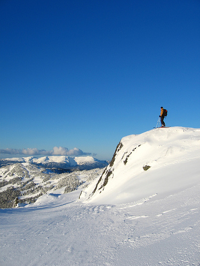

Bleu-score2: 0.3872983346207417


In [47]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
ref_captions = [['skier pauses on mountaintop'],['person on ski looks from hill over snow covered landscape'],['hiker standing high on bluff overlooking the mountains below']]

# generated caption
gen_caption = " man is standing on mountaintop"

# convert reference captions and generated caption to lists of tokens
ref_captions_tok = [tuple(nltk.word_tokenize(caption.lower())) for ref_captions_i in ref_captions for caption in ref_captions_i]
gen_caption_tok = nltk.word_tokenize(gen_caption.lower())
weights=(0.5,0.5,0,0)
# calculate BLEU score
bleu_score = sentence_bleu(ref_captions_tok, gen_caption_tok,weights)
image_path ="106514190_bae200f463.jpg" 
image = Image.open(image_path)
# Display the image
desired_width = 200  # Specify the desired width in pixels
aspect_ratio = desired_width / float(image.size[0])
desired_height = int(image.size[1] * aspect_ratio)
resized_image = image.resize((desired_width, desired_height))
display(resized_image)

print("Bleu-score2:",bleu_score)

In [19]:
clean_descriptions

{'1000268201_693b08cb0e.jpg': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70.jpg': ['black dog and spotted dog are fighting',
  'black dog and tricolored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8.jpg': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young 

Actual
start brown dog is running in grassy plain end
start brown dog runs along path in the grass end
start dog running in field end
start dog running on narrow dirt path end
start the dog is running along path that has been made through the uncut grass end
-------------
predicted: start dog running through the grass end


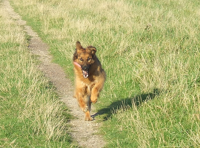

Bleu2-score for LSTM: 0.9128709291752769


In [21]:
from pickle import load
from PIL import Image
import numpy as np
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import Xception
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
#from keras.applications.Xception import preprocess_input
from keras.models import Model
from keras.models import load_model

# extract features from each photo in the directory
def extract_features(filename, model):
        image = Image.open(filename)
    
        image = image.resize((229,229))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
image1="240696675_7d05193aa0.jpg" #"106514190_bae200f463.jpg"
if image1 in clean_descriptions:
    print("Actual")
    for i in clean_descriptions[image1]:
        print("start "+i+" end")
    print("-------------")    
    
# Print the contents of the file
# load the tokenizer
tokenizer = load(open('tokenizer_x.p', 'rb'))
# pre-define the max sequence length (from training)
max_length = 32
# load the model
xception_model = Xception(include_top=False, pooling="avg")
model = load_model('model_19_lstm.h5')
# load and prepare the photograph
photo = extract_features(image1,xception_model)
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print("predicted:",description)
import nltk
from nltk.translate.bleu_score import sentence_bleu
ref_captions = [['brown dog is running in grassy plain'],['brown dog runs along path in the grass'],['dog running in field'],['dog running on narrow dirt path'],['the dog is running along path that has been made through the uncut grass']]

# generated caption
gen_caption = "brown dog is running through the grass"

# convert reference captions and generated caption to lists of tokens
ref_captions_tok = [tuple(nltk.word_tokenize(caption.lower())) for ref_captions_i in ref_captions for caption in ref_captions_i]
gen_caption_tok = nltk.word_tokenize(gen_caption.lower())
weights=(0.5,0.5,0,0)
# calculate BLEU score
bleu_score = sentence_bleu(ref_captions_tok, gen_caption_tok,weights)
image_path =image1 
image = Image.open(image_path)
# Display the image
desired_width = 200  # Specify the desired width in pixels
aspect_ratio = desired_width / float(image.size[0])
desired_height = int(image.size[1] * aspect_ratio)
resized_image = image.resize((desired_width, desired_height))
display(resized_image)

print("Bleu2-score for LSTM:",bleu_score)


Actual
start boy plays in pool with an inflatable toy end
start boy swimming in pool end
start child on pink raft in pool end
start small boy swims with pink floatation device in swimming pool end
start boy playing on pink raft in pool end
-------------
predicted: start child in blue trunks swims underwater in pool end


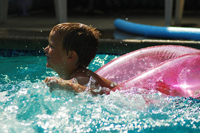

Bleu1-score for LSTM: 0.5


In [24]:
from pickle import load
from PIL import Image
import numpy as np
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import Xception
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
#from keras.applications.Xception import preprocess_input
from keras.models import Model
from keras.models import load_model

# extract features from each photo in the directory
def extract_features(filename, model):
        image = Image.open(filename)
    
        image = image.resize((229,229))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
image1="799199774_142b1c3bb2.jpg"#'240696675_7d05193aa0.jpg'
if image1 in clean_descriptions:
    print("Actual")
    for i in clean_descriptions[image1]:
        print("start "+i+" end")
    print("-------------")    
    
# Print the contents of the file
# load the tokenizer
tokenizer = load(open('tokenizer_x.p', 'rb'))
# pre-define the max sequence length (from training)
max_length = 32
# load the model
xception_model = Xception(include_top=False, pooling="avg")
model = load_model('model_19_Lstm.h5')
# load and prepare the photograph
photo = extract_features(image1,xception_model)
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print("predicted:",description)
import nltk
from nltk.translate.bleu_score import sentence_bleu
ref_captions = [['boy swimming in pool'],['boy plays in pool with an inflatable toy'],['child on pink raft in pool'],['small boy swims with pink floatation device in swimming pool'],['']]

# generated caption
gen_caption = "child in blue trunks swims underwater in pool"

# convert reference captions and generated caption to lists of tokens
ref_captions_tok = [tuple(nltk.word_tokenize(caption.lower())) for ref_captions_i in ref_captions for caption in ref_captions_i]
gen_caption_tok = nltk.word_tokenize(gen_caption.lower())
weights=(1,0,0,0)
# calculate BLEU score
bleu_score = sentence_bleu(ref_captions_tok, gen_caption_tok,weights)
image_path =image1 
image = Image.open(image_path)
# Display the image
desired_width = 200  # Specify the desired width in pixels
aspect_ratio = desired_width / float(image.size[0])
desired_height = int(image.size[1] * aspect_ratio)
resized_image = image.resize((desired_width, desired_height))
display(resized_image)

print("Bleu1-score for LSTM:",bleu_score)


predicted: start soccer player in red kicks up for the ball end


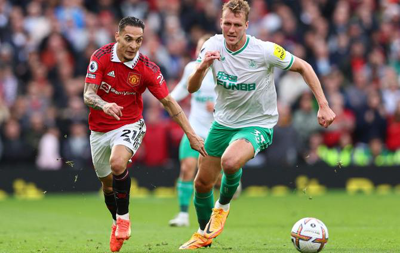

In [71]:
from pickle import load
from PIL import Image
import numpy as np
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import Xception
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
#from keras.applications.Xception import preprocess_input
from keras.models import Model
from keras.models import load_model

# extract features from each photo in the directory
def extract_features(filename, model):
        image = Image.open(filename)
    
        image = image.resize((229,229))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
image1='new3.jpg'
    
# Print the contents of the file
# load the tokenizer
tokenizer = load(open('tokenizer_x.p', 'rb'))
# pre-define the max sequence length (from training)
max_length = 32
# load the model
xception_model = Xception(include_top=False, pooling="avg")
model = load_model('model_19.h5')
# load and prepare the photograph
photo = extract_features(image1,xception_model)
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print("predicted:",description)
image_path =image1 
image = Image.open(image_path)
# Display the image
desired_width = 400  # Specify the desired width in pixels
aspect_ratio = desired_width / float(image.size[0])
desired_height = int(image.size[1] * aspect_ratio)
resized_image = image.resize((desired_width, desired_height))
display(resized_image)

predicted for LSTM: start man is fishing in the ocean end


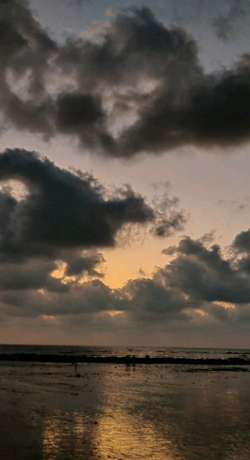

In [8]:
from pickle import load
from PIL import Image
import numpy as np
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import Xception
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
#from keras.applications.Xception import preprocess_input
from keras.models import Model
from keras.models import load_model

# extract features from each photo in the directory
def extract_features(filename, model):
        image = Image.open(filename)
    
        image = image.resize((229,229))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
image1='beach.jpeg'
    
# Print the contents of the file
# load the tokenizer
tokenizer = load(open('tokenizer_x.p', 'rb'))
# pre-define the max sequence length (from training)
max_length = 32
# load the model
xception_model = Xception(include_top=False, pooling="avg")
model = load_model('model_19_lstm.h5')
# load and prepare the photograph
photo = extract_features(image1,xception_model)
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print("predicted for LSTM:",description)
image_path =image1 
image = Image.open(image_path)
# Display the image
desired_width = 250  # Specify the desired width in pixels
aspect_ratio = desired_width / float(image.size[0])
desired_height = int(image.size[1] * aspect_ratio)
resized_image = image.resize((desired_width, desired_height))
display(resized_image)